map the problem to circuit

In [20]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label = r'$\sqrt{y}$')
SYdgGate = UnitaryGate(YGate().inverse(), label = r'$\sqrt{y}^dag$')

def generate_1d_tfim_circuit(num_qubits,num_trotter_steps,rx_angle,num_cls_bits = 0,trotter_barriers=False,layer_barriers=False):
    if num_cls_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits,num_cls_bits)

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc,rx_angle,layer_barriers)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_1d_tfim_trotter_layer(qc,rx_angle,layer_barriers = False):
    #add rzz gate in even
    for i in range(0,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    #odd layer
    for i in range(1,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

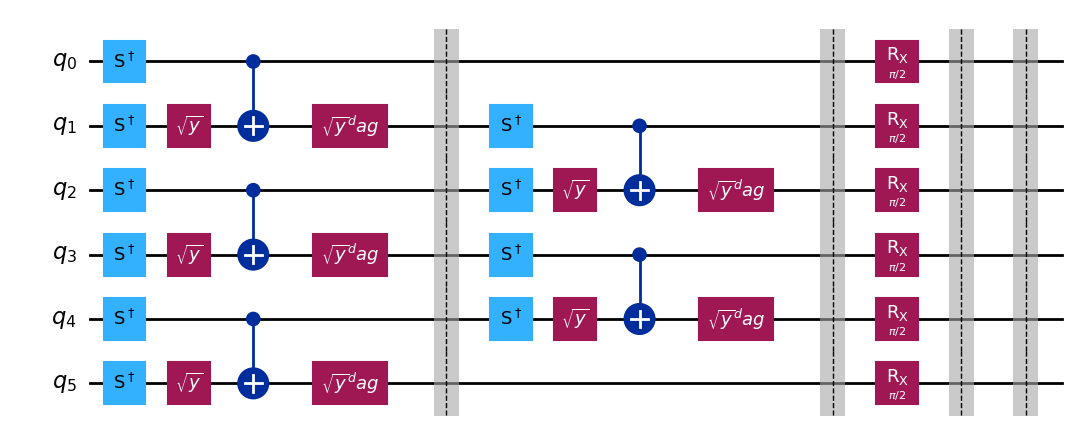

In [21]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi
qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps,rx_angle,trotter_barriers=True,layer_barriers=True)
qc.draw(output='mpl',fold=-1)


demo sampler

In [22]:
 def append_mirrored_1d_tfim_circuit(qc,num_qubits,num_trotter_steps,rx_angle,trotter_barriers=False,layer_barriers=False):

    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc,rx_angle,layer_barriers)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc,rx_angle,layer_barriers = False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    #odd layer
    for i in range(1,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()
    #odd layer
    for i in range(0,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()


    

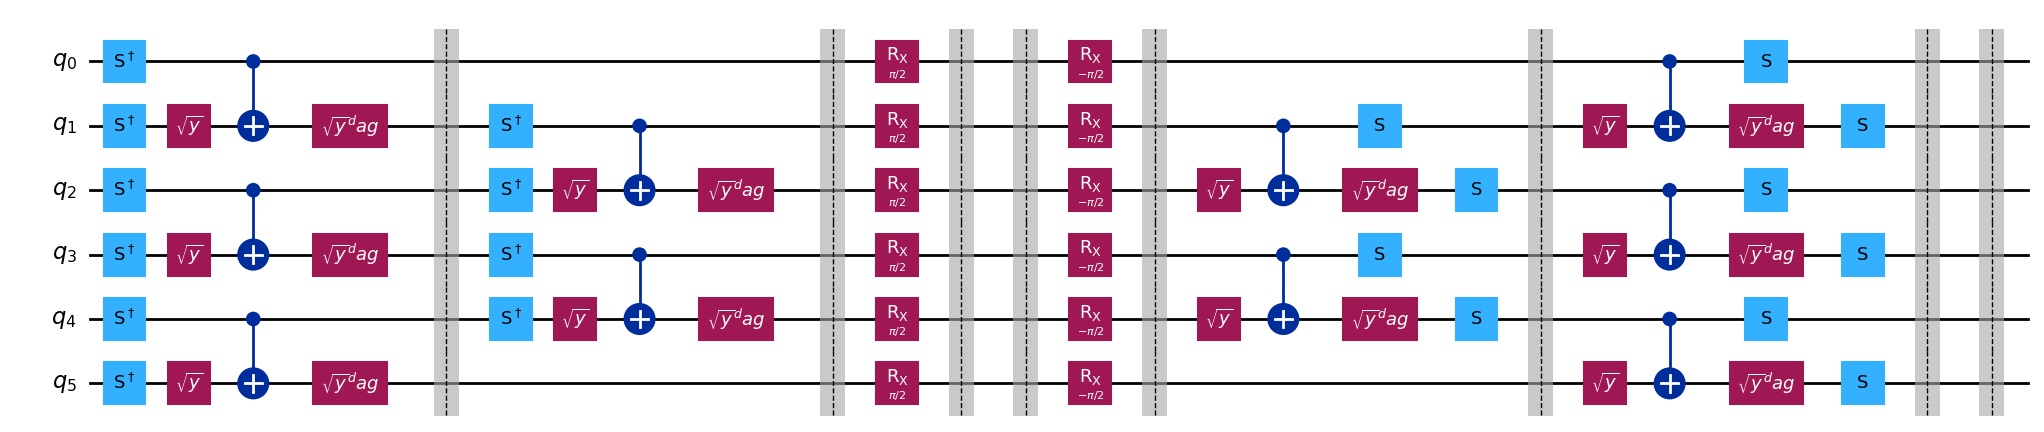

In [23]:
append_mirrored_1d_tfim_circuit(qc,num_qubits,num_trotter_steps,rx_angle,trotter_barriers=True,layer_barriers=True)
qc.draw(output='mpl',fold=-1)

map the problem to circuit

In [24]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49,50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc =generate_1d_tfim_circuit(num_qubits, num_trotter_steps,rx_angle,num_cls_bits= len(measured_qubits),trotter_barriers=True,layer_barriers=True)
    append_mirrored_1d_tfim_circuit(qc,num_qubits,num_trotter_steps,rx_angle,trotter_barriers=True,layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

optimize

In [34]:
from qiskit import transpile
from qiskit_ibm_runtime import  QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print("done backend")
qc_transpile_list  = transpile(qc_list,backend=backend,optimization_level=1)

done backend


backend execution

In [39]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
job = sampler.run(qc_transpile_list)
print(job.job_id)

<bound method BasePrimitiveJob.job_id of <RuntimeJobV2('cw32mg24v2e0008smp10', 'sampler')>>


post-process and ploting

In [40]:
job_id = "cw32mg24v2e0008smp10"
job = service.job(job_id)

survival_probabiity_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probabiity_list.append(data.c.get_counts()['0'* len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probabiity_list.append(0)

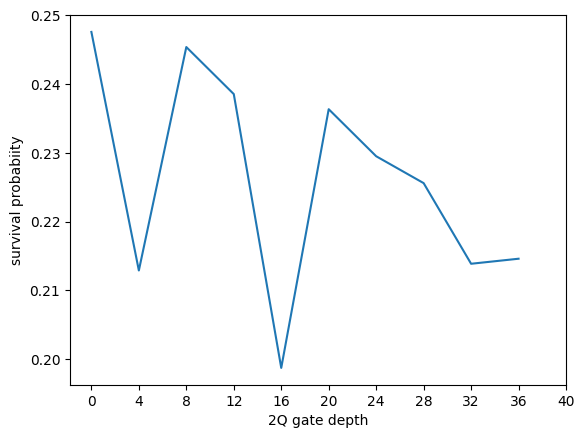

In [54]:
import  matplotlib.pyplot as plt
import numpy as numpy

plt.plot(list(range(0,4* max_trotter_steps,4)),survival_probabiity_list)
plt.xlabel('2Q gate depth')
plt.ylabel('survival probabiity')
plt.xticks(numpy.arange(0,44,4))
plt.show()